In [21]:
import time
import timeit
from enum import Enum
import math
import matplotlib.pyplot as plt
import numpy as np

# one step binomial
from enum import Enum
import math
import matplotlib.pyplot as plt
#from intro import opTiming

In [22]:
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'
    BinaryCall = 'BinaryCall'
    BinaryPut = 'BinaryPut'

def oneStepBinomial(S:float, r:float, u:float, d:float, optType:PayoffType, K:float, T:float) -> float:
    p = (math.exp(r * T) - d) / (u-d)
    if optType == PayoffType.Call:
        return math.exp(-r*T) * (p*max(S*u-K, 0) + (1-p) * max(S*d-K, 0))

In [23]:
oneStepBinomial(S=100, r=0.01, u=1.2, d=0.8, optType=PayoffType.Call, K=105, T=1.0)

7.798504987524955

In [24]:
# Black-Scholes analytic pricer
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def bsPrice(S, r, vol, T, strike, payoffType):
    fwd = S * math.exp(r * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    elif payoffType == PayoffType.BinaryCall:
        return math.exp(-r * T) * cnorm(d2)
    elif payoffType == PayoffType.BinaryPut:
        return math.exp(-r * T) * (cnorm(-d2))
    else:
        raise Exception("not supported payoff type", payoffType)


primary binomial tree: u and d as input

In [25]:
# test ---
S, r, vol, K, T, u, d = 100, 0.01, 0.2, 105, 1.0, 1.2, 0.8
print("blackPrice: ", bsPrice(S, r, vol, T, K, PayoffType.Call))
print("oneStepTree: ", oneStepBinomial(S, r, u, d, PayoffType.Call, K, T))

blackPrice:  6.297254539086019
oneStepTree:  7.798504987524955


calibrated binomial tree: u and d as function of (r, T, $\sigma$)

In [26]:
def oneStepBinomial2(S, r, vol, optType, K, T):
    b = math.exp(vol * vol * T+r*T) + math.exp(-r * T)
    u = (b + math.sqrt(b*b - 4)) / 2
    d = 1/u
    p = (math.exp(r * T) - d) / (u-d)
    if optType == PayoffType.Call:
        return math.exp(-r * T) * (p * max(S * u - K, 0) + (1-p) * max(S * d - K, 0))

In [27]:
# test ---
S,r,vol,K,T,u,d = 100, 0.01, 0.2, 105, 1.0, 1.2, 0.8
print("blackPrice: ", bsPrice(S, r, vol, T, K, PayoffType.Call))
print("oneStepTree1: \t", oneStepBinomial(S, r, u, d, PayoffType.Call, K, T))
print("oneStepTree2: \t", oneStepBinomial2(S, r, vol, PayoffType.Call, K, T))

blackPrice:  6.297254539086019
oneStepTree1: 	 7.798504987524955
oneStepTree2: 	 8.212289615248919


N-steps binomial tree simulation

In [28]:
def crrBinomial(S, r, vol, payoffType, K, T, n):
    t = T / n
    b = math.exp(vol * vol * t+r*t) + math.exp(-r * t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (math.exp(r * t) - (1/u)) / (u - 1/u)
    # set up the last time slice, there are n+1 nodes at the last time slice
    payoffDict = {
        PayoffType.Call: lambda s: max(s-K, 0),
        PayoffType.Put: lambda s: max(K-s, 0),
    }
    vs = [payoffDict[payoffType]( S * u**(n-i-i)) for i in range(n+1)]
    # iterate backward
    for i in range(n-1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i+1):
            vs[j] = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
    return vs[0]

> # for testing on QF633 cpp project pricer

In [42]:
# test ---
n = 300
S, r, vol, K, T = 652, 0.0541448, 0.146648, 700, 1.60799
print("blackPrice: \t", bsPrice(S, r, vol, T, K, PayoffType.Call))
print("crrNStepTree: \t", crrBinomial(S, r, vol, PayoffType.Call, K, T, n))

start = time.time()
crrBinomial(S, r, vol, PayoffType.Call, K, T, n)
print("crr Binomial Tree pricing time: ", time.time() - start)

start = time.time()
bsPrice(S, r, vol, T, K, PayoffType.Call)
print("BS close form formula pricing time: ", (time.time() - start) * 1e9)

blackPrice: 	 53.2773335643577
crrNStepTree: 	 53.31518931914591
crr Binomial Tree pricing time:  0.006474018096923828
BS close form formula pricing time:  0.0


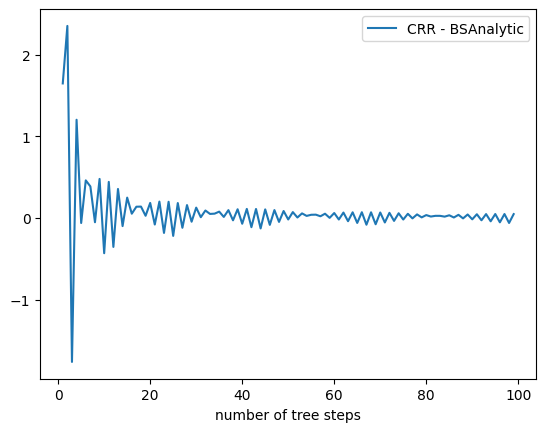

In [30]:
# import matplotlib.pyplot as plt
n = 100
S, r, vol, K, T = 652, 0.0552022, 0.2285, 690, 0.166667
bsPrc = bsPrice(S, r, vol, T, K, PayoffType.Call)
crrErrs = [(crrBinomial(S,r,vol,PayoffType.Call,K,T,i) - bsPrc) for i in range(1, n)]

plt.plot(range(1, n), crrErrs, label = "CRR - BSAnalytic")
plt.xlabel('number of tree steps')
plt.legend()
# plt.yscale('log')
plt.show()

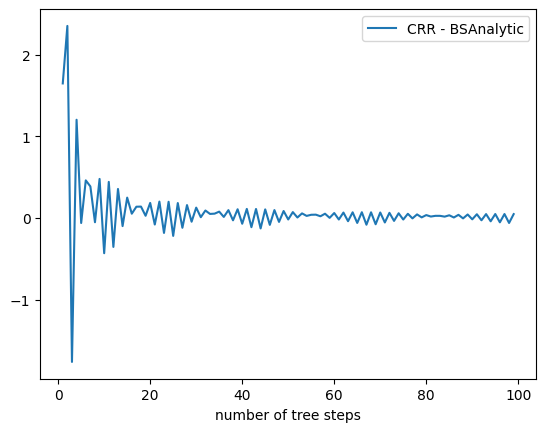

In [31]:


# import matplotlib.pyplot as plt
n = 100
S, r, vol, K, T = 652, 0.0552022, 0.2285, 690, 0.166667
bsPrc = bsPrice(S, r, vol, T, K, PayoffType.Call)
crrErrs = [(crrBinomial(S,r,vol,PayoffType.Call,K,T,i) - bsPrc) for i in range(1, n)]

plt.plot(range(1, n), crrErrs, label = "CRR - BSAnalytic")
plt.xlabel('number of tree steps')
plt.legend()
# plt.yscale('log')
plt.show()

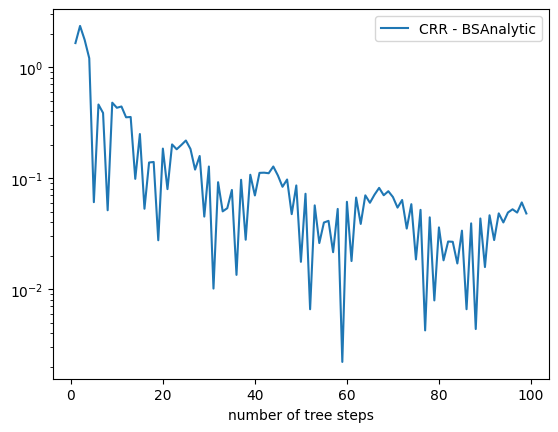

In [32]:
# import matplotlib.pyplot as plt
n = 100
S, r, vol, K, T = 652, 0.0552022, 0.2285, 690, 0.166667
bsPrc = bsPrice(S, r, vol, T, K, PayoffType.Call)
crrErrs = [abs(crrBinomial(S,r,vol,PayoffType.Call,K,T,i) - bsPrc) for i in range(1, n)]

plt.plot(range(1, n), crrErrs, label = "CRR - BSAnalytic")
plt.xlabel('number of tree steps')
plt.yscale('log') # plot on log scale
plt.legend()
plt.savefig('BinomialTreeLogScaleY.png')


Americal Option Pricing by Binomial tree

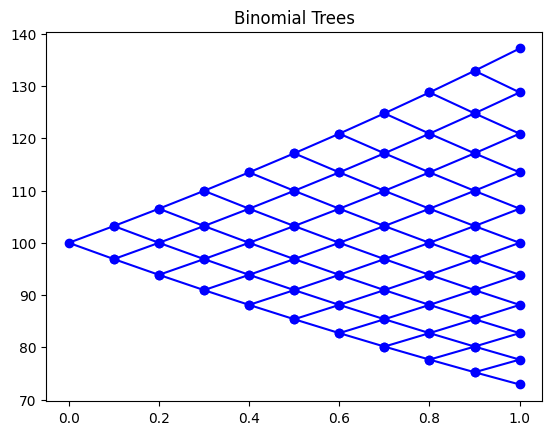

probs:  [[], [0.5237170824512629], [0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.523717

In [33]:
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        elif self.payoffType == PayoffType.BinaryCall:
            if S > self.strike:
                return 1.0
            else:
                return 0.0
        elif self.payoffType == PayoffType.BinaryPut:
            if S < self.strike:
                return 1.0
            else:
                return 0.0
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

class AmericanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

class KnockOutOption():
    def __init__(self, downBarrier, upBarrier, barrierStart, barrierEnd, underlyingOption):
        self.underlyingOption = underlyingOption
        self.barrierStart = barrierStart
        self.barrierEnd = barrierEnd
        self.downBarrier = downBarrier
        self.upBarrier = upBarrier
        self.expiry = underlyingOption.expiry
    def payoff(self, S):
        return self.underlyingOption.payoff(S)
    def valueAtNode(self, t, S, continuation):
        if t > self.barrierStart and t < self.barrierEnd:
            if self.upBarrier != None and S > self.upBarrier:
                return 0
            elif self.downBarrier != None and S < self.downBarrier:
                return 0
        return continuation

class AsianOption():
    def __init__(self, fixings, payoffFun, As, nT):
        self.fixings = fixings
        self.payoffFun = payoffFun
        self.expiry = fixings[-1]
        self.nFixings = len(fixings)
        self.As, self.nT = nT
        self.dt = self.expiry / nT
    def onFixingDate(self, t):
        # we say t is on a fixing date if there is a fixing date T_i \in (t-dt, t]
        return filter(lambda x: x > t - self.dt and x<=t, self.fixings)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return [self.payoffFun((a*(self.nFixings-1) + S)/self.nFixings) for a in self.As]
        else:
            if self.onFixingDate(t):
                i = len(filter(lambda x: x < t, self.fixings)) # number of previous fixings
                Ahats = [(a*(i-1) + S)/i for a in self.As]
                nodeValues = [np.interp(a, self.As, continuation) for a in Ahats]
            else:
                nodeValues = continuation
        return nodeValues


def crrBinomialG(S, r, vol, trade, n):
    t = trade.expiry / n
    b = math.exp(vol * vol * t+r*t) + math.exp(-r * t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (math.exp(r * t) - (1/u)) / (u - 1/u)
    # d = 1 / u
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff( S * u**(n-i-i)) for i in range(n+1)]
    # iterate backward
    for i in range(n-1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i+1):
            nodeS = S * u**(i-j-j)
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
            vs[j] = trade.valueAtNode(t*i, nodeS, continuation)
    return vs[0]

############ binomial pricer and different binomial models
def simpleCRR(r, vol, t):
    u = math.exp(vol * math.sqrt(t))
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1 / u, p)

def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

def test1DTiming():
    opt = EuropeanOption(1, 105, PayoffType.Call)
    S, r, vol = 100, 0.01, 0.2

    bsprc = bsPrice(S, r, vol, opt.expiry, opt.strike, opt.payoffType)
    print("bsPrice = \t ", bsprc)
    n = 20
    prc = [None] * n
    timing = [None] * n
    nSteps = [None] * n
    for i in range(1, n + 1):
        nSteps[i - 1] = 20 * i
        start = time.time()
        prc[i - 1] = binomialPricer(S, r, vol, opt, nSteps[i - 1], tianCalib) - bsprc
        timing[i - 1] = time.time() - start

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(nSteps, prc, 'g')
    ax2.plot(nSteps, timing, 'b')

    ax1.set_xlabel('nTreeSteps')
    ax1.set_ylabel('Pricing Error')
    ax2.set_ylabel('Timeing')
    plt.legend()
    plt.show()

def testBTrees():
    opt = EuropeanOption(1, 105, PayoffType.Call)
    S, r, vol = 100, 0.01, 0.2

    bsprc = bsPrice(S, r, vol, opt.expiry, opt.strike, opt.payoffType)
    print("bsPrice = \t ", bsprc)
    n = 300

    crrErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, crrCalib) - bsprc)) for i in range(1, n)]
    jrrnErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, jrrnCalib) - bsprc)) for i in range(1, n)]
    jreqErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, jreqCalib) - bsprc)) for i in range(1, n)]
    tianErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, tianCalib) - bsprc)) for i in range(1, n)]

    plt.plot(range(1, n), crrErrs, label="crr")
    plt.plot(range(1, n), jrrnErrs, label="jrrn")
    plt.plot(range(1, n), jreqErrs, label="jreq")
    plt.plot(range(1, n), tianErrs, label="tian")
    plt.legend()
    plt.show()

class EuropeanPayoff():
    def __init__(self, expiry, payoffFun):
        self.expiry = expiry
        self.payoffFun = payoffFun
    def payoff(self, S):
        return self.payoffFun(S)
    def valueAtNode(self, t, S, continuation):
        return continuation

class AmericanPayoff():
    def __init__(self, expiry, payoffFun):
        self.expiry = expiry
        self.payoffFun = payoffFun
    def payoff(self, S):
        return self.payoffFun(S)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

def testAmerSpread():
    S, r, vol = 95, 0.05, 0.2
    callSpread = lambda S: min(max(S - 90, 0), 10)
    plt.plot(range(80, 120), [callSpread(i) for i in range(80, 120)])
    plt.show()
    print("Euro callspread: ", binomialPricer(S, r, vol, EuropeanPayoff(1, callSpread), 300, crrCalib))
    print("Amer callspread: ", binomialPricer(S, r, vol, AmericanPayoff(1, callSpread), 300, crrCalib))

def additiveBinomialTree(S, r, q, vol, T, n):
    t = T / n
    treeNodes = [[0]] # at t = 0, only one node,
    probs = [[]]
    dx = vol * math.sqrt(t)
    for i in range(1, n+1):
        # calculate the value of each node at time slide i, there are i+1 nodes
        slice = [0] * (i+1)
        for j in range(i):
            slice[j] = treeNodes[i-1][j] + dx
        slice[i] = treeNodes[i-1][i-1] - dx
        prob = [0] * (i)
        for j in range(i):
            prob[j] = ((r-q-0.5*vol*vol)*t + dx) / 2 / dx
        treeNodes.append(slice)
        probs.append(prob)
    return treeNodes, probs


if __name__ == "__main__":
    # test1DTiming()
    # testAmerSpread()
    S0, r, q, vol = 100, 0.03, 0.01, 0.1
    T, nT = 1, 10
    dt = T / nT
    treeNodes, probs = additiveBinomialTree(S0, r, q, vol, T, nT)
    fig = plt.figure()
    for i in range(len(treeNodes)-1):
        x = [dt, 0, dt]
        for j in range(i):
            x += [0, dt]
        x = np.array(x) + i*dt
        y = treeNodes[i] + treeNodes[i+1]
        y.sort()
        y = [S0 * math.exp(x) for x in y]
        plt.plot(x, y, 'bo-')
    plt.title("Binomial Trees")
    plt.show()
    print("probs: ", probs)




Testing Binomial Tree Pricer with American Option


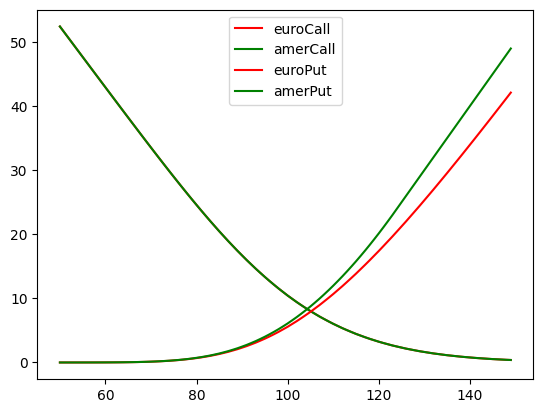

In [34]:
euroPrc, amerPrc = [],[]
S, r, vol = 100, 0.05, 0.2
ks = range(50, 150)
for k in ks:
    euroPrc.append(crrBinomialG(S, 
                                r, 
                                vol, 
                                EuropeanOption(1, 
                                               float(k), 
                                               PayoffType.Call), 
                                300))
    amerPrc.append(crrBinomialG(S, 
                                r, 
                                vol, 
                                AmericanOption(1, 
                                               float(k), 
                                               PayoffType.Call), 
                                300))

plt.plot(ks, euroPrc, 'r', label='euroCall')
plt.plot(ks, amerPrc, 'g', label='amerCall')
euroPrc, amerPrc = [], []

for k in ks:
    euroPrc.append(crrBinomialG(S, 
                                r, 
                                vol, 
                                EuropeanOption(1, 
                                               float(k), 
                                               PayoffType.Put), 
                                300))
    amerPrc.append(crrBinomialG(S, 
                                r, 
                                vol, 
                                AmericanOption(1, 
                                               float(k), 
                                               PayoffType.Put), 
                                300))
plt.plot(ks, euroPrc, 'r', label='euroPut')
plt.plot(ks, amerPrc, 'g', label='amerPut')
plt.legend()
plt.show()


Pricing a Call Spread

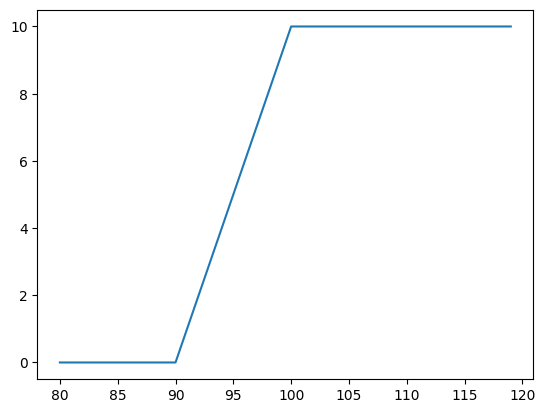

Euro callspread:  6.259190489574921
Amer callspread:  10.0


In [35]:
S, r, vol = 100, 0.05, 0.2
callSpread = lambda S: min(max(S-90, 0), 10)
plt.plot(range(80, 120), [callSpread(i) for i in range(80, 120)] )
plt.show()

print("Euro callspread: ", crrBinomialG(S, 
                                        r, 
                                        vol, 
                                        EuropeanPayoff(1, 
                                                       callSpread), 
                                        300))
print("Amer callspread: ", crrBinomialG(S, 
                                        r, 
                                        vol, 
                                        AmericanPayoff(1, 
                                                       callSpread), 
                                        300))


> Barrier Option Class

In [36]:
class BarrierOption():
    def __init__(self, downBarrier, upBarrier, barrierStart, barrierEnd, underlyingOption):
        self.underlyingOption = underlyingOption
        self.barrierStart = barrierStart
        self.barrierEnd = barrierEnd
        self.downBarrier = downBarrier
        self.upBarrier = upBarrier
        self.expiry = underlyingOption.expiry
    def payoff(self, S):
        return self.underlyingOption.payoff(S)
    def valueAtNode(self, t, S, continuation):
        if t > self.barrierStart and t < self.barrierEnd:
            if self.upBarrier != None and S > self.upBarrier:
                return 0
            elif self.downBarrier != None and S < self.downBarrier:
                return 0
        return continuation

Testing Barrier Options — Up Barriers

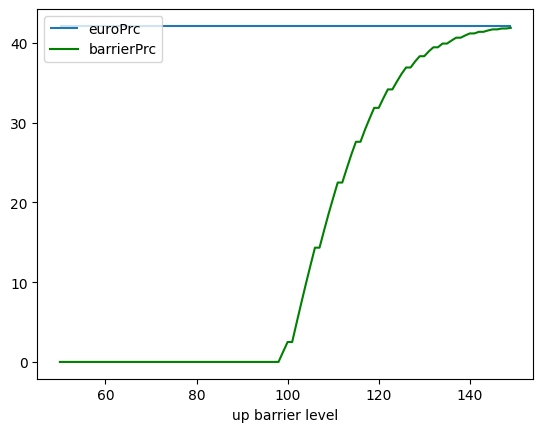

In [37]:
# varying up barrier
S, r, vol, K = 100, 0.05, 0.2, 105
eurOpt = EuropeanOption(1, k, PayoffType.Put)
euroPrc = crrBinomialG(S, r, vol, eurOpt, 300)
barrierPrc, ks = [], range(50, 150)
for barrierLevel in ks:
    prc =\
        crrBinomialG(S, r, vol, 
                     BarrierOption(barrierStart = 0, 
                                   barrierEnd = 1.0, 
                                   downBarrier = None,
                                   upBarrier = barrierLevel, 
                                   underlyingOption = eurOpt), 
                     n = 300)
    barrierPrc.append(prc)
plt.hlines(euroPrc, ks[0], ks[-1], label = 'euroPrc')
plt.plot(ks, barrierPrc, 'g', label='barrierPrc')
plt.xlabel('up barrier level') 
plt.legend()
plt.savefig('Up Barriers Testing.png')

Testing Barrier Options — Down Barriers

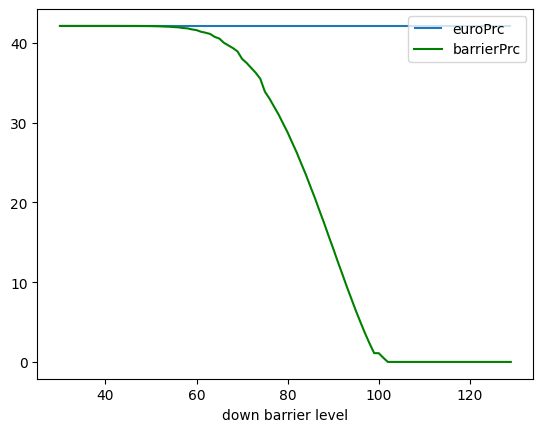

In [38]:
# varying down barrier
S, r, vol, K = 100, 0.05, 0.2, 105
eurOpt = EuropeanOption(1, k, PayoffType.Put)
euroPrc = crrBinomialG(S, r, vol, eurOpt, 300)
barrierPrc, ks = [], range(30, 130)
for barrierLevel in ks:
    prc =\
        crrBinomialG(S, r, vol, 
                     BarrierOption(barrierStart = 0,
                                   barrierEnd = 1.0, 
                                   downBarrier = barrierLevel, 
                                   upBarrier = None, 
                                   underlyingOption = eurOpt),
                     n = 300)
    barrierPrc.append(prc)
plt.hlines(euroPrc, ks[0], ks[-1], label = 'euroPrc')
plt.plot(ks, barrierPrc, 'g', label='barrierPrc')
plt.xlabel('down barrier level')
plt.legend()
plt.savefig('Up Barriers Testing.png')


Testing Barrier Options — 1st Window Barriers

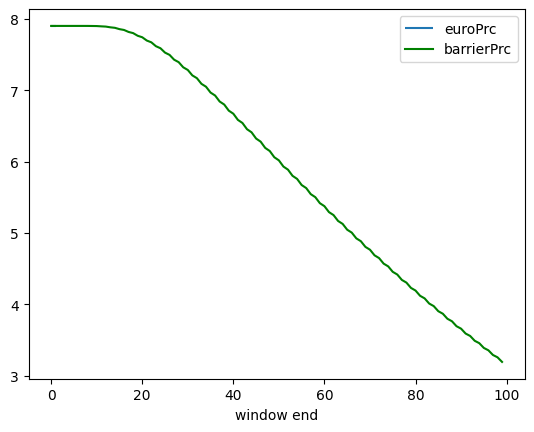

In [39]:
# varying barrier window, barrier end
S, r, vol, k = 100, 0.05, 0.2, 105
eurOpt = EuropeanOption(1, k, PayoffType.Put)
euroPrc = crrBinomialG(S, r, vol, eurOpt, 300)
barrierPrc = []
ks = range(0, 100)
for t in ks:
    prc =\
        crrBinomialG(S, r, vol, 
                     BarrierOption(barrierStart = 0, 
                                   barrierEnd = t / 100.0, 
                                   downBarrier = 80, 
                                   upBarrier = 150, 
                                   underlyingOption = eurOpt), 
                     n = 300)
    barrierPrc.append(prc)
plt.hlines(euroPrc, ks[0], ks[-1] / 100, label = 'euroPrc')
plt.plot(ks, barrierPrc, 'g', label='barrierPrc')
plt.legend()
plt.xlabel('window end')
plt.savefig('1st Window Barriers.png')


Testing Barrier Options — 2nd Window Barriers

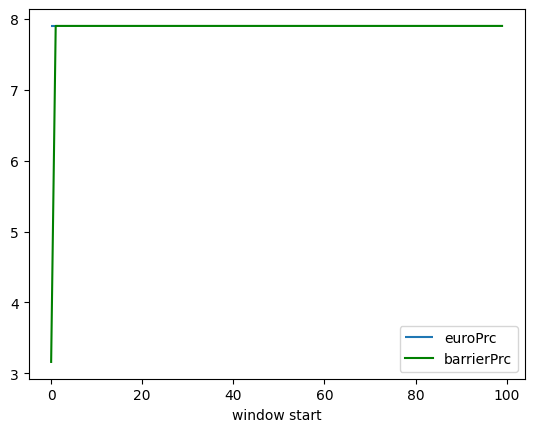

In [40]:
# varying barrier window, barrier start
S, r, vol, k = 100, 0.05, 0.2, 105
eurOpt = EuropeanOption(1, k, PayoffType.Put)
euroPrc = crrBinomialG(S, r, vol, eurOpt, 300)
barrierPrc = []
ks = range(0, 100)
for t in ks:
    prc =\
        crrBinomialG(S, r, vol,
                     BarrierOption(barrierStart = t,
                                   barrierEnd = 1, 
                                   downBarrier = 80,
                                   upBarrier = 150, 
                                   underlyingOption = eurOpt),
                     n = 300)
    barrierPrc.append(prc)
plt.hlines(euroPrc, ks[0], ks[-1] / 100, label = 'euroPrc')
plt.plot(ks, barrierPrc, 'g', label='barrierPrc')
plt.legend()
plt.xlabel('window start')
plt.savefig('1st Window Barriers.png')